In [2]:
import gzip
import pickle
import time
import tqdm

# Third-party libraries
import numpy as np



In [3]:
def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    with gzip.open('../MNIST/data/mnist.pkl.gz', 'rb') as f:
        training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [4]:
training_data, validation_data, test_data = load_data_wrapper()

In [5]:
#import os
#print(os.getcwd())

In [6]:
## Initialize Network Dimensions
## number of layers are fixed to 3: Input a_0, Middle (hidden) a_1, Output a_2
## number of input nodes:
n_nodes_0 = 784
n_nodes_1 = 20
n_nodes_2 = 10


In [7]:
## Ininitalize weight matrices and bias vectors and activation functions AF
## Definitions for matrix multiplication and activation funcions: a_(k+1) = af_k(v_k)
## v_k = w_k @ a_k + b_k
mean = 0.0
std = 0.05

def init_wb():
    global w_0, w_1, b_0, b_1
    w_0 = np.random.normal(mean, std, size=[n_nodes_1, n_nodes_0])
    w_1 = np.random.normal(mean, std, size=[n_nodes_2, n_nodes_1])
    b_0 = np.zeros(n_nodes_1)
    b_1 = np.zeros(n_nodes_2)
    return()


In [8]:
## Set af_0 to relu
def af_0(vec):
    return np.maximum(0, vec)

## Set af_1 to softmax
def af_1(vec):
    return(np.exp(vec)/np.exp(vec).sum())

## Derivative of af_0 (Relu):
def d_af_0(vec):
    return(np.diagflat(np.heaviside(vec, 1)))

## Derivative of af_1 (Softmax):
def d_af_1(vec):
    expsum = np.exp(vec).sum()
    return(np.diagflat(np.exp(vec))/expsum - np.outer(vec, vec)/expsum**2)


In [9]:
## Define forward propagation
def fwd_prop(v_in):
    v_0 = w_0 @ v_in + b_0
    a_1 = af_0(v_0)
    v_1 = w_1 @ a_1 + b_1
    a_2 = af_1(v_1)
    return v_0, a_1, v_1, a_2

In [10]:
def backw_prop(v_in, v_target):
    v_2 = v_target-a_2
    loss = np.dot(v_2, v_2)
    dL_db1 = -2*v_2 @ d_af_1(v_1)
    dL_dW1 = np.outer(dL_db1, a_1)
    dL_db0 = dL_db1 @ w_1 @ d_af_0(v_0)
    dL_dW0 = np.outer(dL_db0, v_in)
    return loss, dL_db1, dL_dW1, dL_db0, dL_dW0

In [11]:
np.random.seed(307)
init_wb()
l_rate = 0.01
batchsize = 200
epochs = 1
loss_vector = np.zeros(epochs)
start_time = time.time()
for epoch in tqdm.tqdm(range(epochs)):
   #define sums to average over minibatches
    loss_s = dL_dW0_s = dL_dW1_s = dL_db0_s = dL_db1_s = 0.0
    batch_sample = np.random.choice(np.arange(len(training_data)), size=batchsize, replace=False)
    for batch in batch_sample:
        v_0, a_1, v_1, a_2 = fwd_prop(training_data[batch][0].flatten())
        loss, dL_db1, dL_dW1, dL_db0, dL_dW0 = backw_prop(training_data[batch][0].flatten(), training_data[batch][1].flatten())
        loss_s += loss
        dL_dW0_s += dL_dW0
        dL_dW1_s += dL_dW1
        dL_db0_s += dL_db0
        dL_db1_s += dL_db1
    
    w_0 += -l_rate*dL_dW0_s/batchsize
    w_1 += -l_rate*dL_dW1_s/batchsize
    b_0 += -l_rate*dL_db0_s/batchsize
    b_1 += -l_rate*dL_db1_s/batchsize
    loss_vector[epoch] = loss_s/batchsize

print("Elapsed time: %.2f seconds" % (time.time()-start_time))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

Elapsed time: 0.13 seconds


In [19]:
## Test with Test Data and calculate accuracy:
pred_array = np.zeros(len(test_data))
for _ in range(len(test_data)):
    pred_array[_] = np.argmax(fwd_prop(test_data[_][0].flatten())[3]) - test_data[_][1] 

np.count_nonzero(pred_array)/(len(test_data))

0.1272

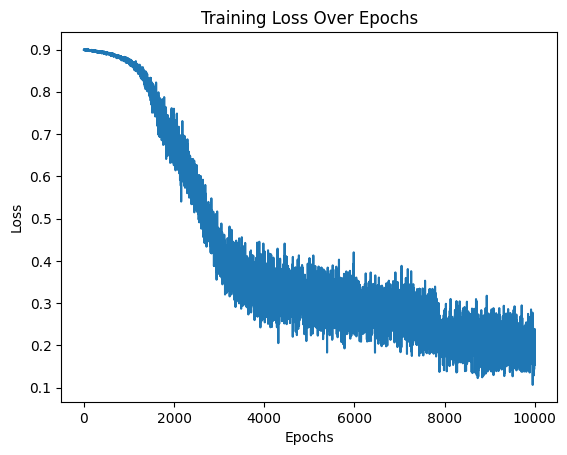

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_vector)), loss_vector)

# Adding axis labels
plt.xlabel('Epochs')  # Label for the X-axis
plt.ylabel('Absolute L2-Loss')    # Label for the Y-axis

# Optional: Adding a title to the plot
plt.title('Training Loss Over Epochs')

plt.show()  # Display the plot

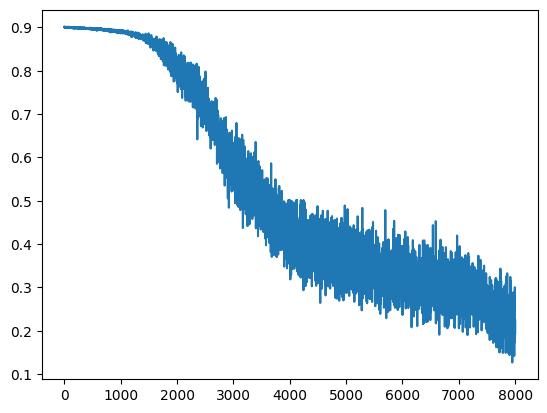

In [276]:
plt.plot(np.arange(len(loss_vector)), loss_vector)

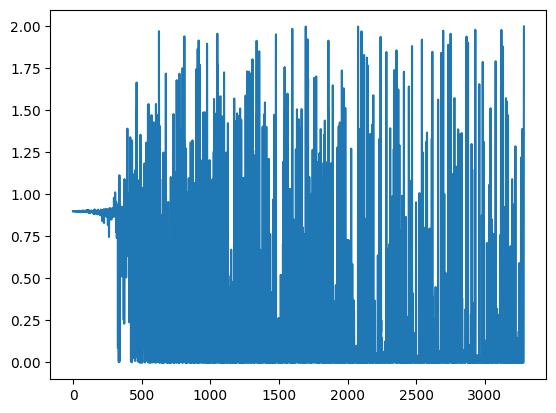

In [19]:
plt.plot(np.arange(len(loss_vector)), loss_vector)

In [103]:
np.random.seed(307)
print(np.random.randint(0, 10))

5
